## Implement linear regression in tensorflow


About loading models

- https://github.com/Hvass-Labs/TensorFlow-Tutorials
- https://kevincodeidea.wordpress.com/2016/08/02/tensorflow-save-and-load-a-model-in-a-serious-way-from-different-files/



In [1]:
import tensorflow as tf
from tensorflow.contrib import learn
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib
    
import numpy as np
import matplotlib
from matplotlib  import pyplot as plt
import pprint
%matplotlib inline
np.__version__, tf.__version__

('1.13.0', '1.2.0')

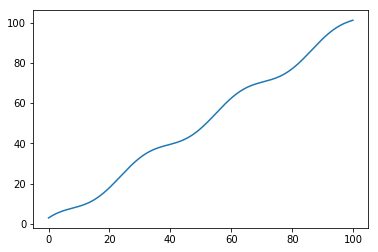

In [2]:
x = np.arange(100, step=0.1)
y = x + 3 * np.cos(x/5)  
plt.plot(x, y)

In [3]:
n_samples = 1000
batch_size = 10

# rewrite as column vector
x = np.reshape(x, (n_samples, 1))
y = np.reshape(y, (n_samples, 1)) 

## Defining the graph for the linear regressor

In [4]:
x.shape

(1000, 1)

In [5]:
c = np.array([[3.,4], [5.,6], [6.,7]])
print(np.mean(c,1))

[ 3.5  5.5  6.5]


In [6]:
tf.reset_default_graph()
batch_size_ = 50
n_features_ = 1
linear_regression_graph = tf.Graph()
seed_val = 123

with linear_regression_graph.as_default():
    batch_size = batch_size_
    n_features = n_features_

    pl_x = tf.placeholder(name="pl_x", dtype=tf.float32, shape=(None, 1))
    pl_y = tf.placeholder(name="pl_y", dtype=tf.float32, shape=(None, 1))
    W = tf.get_variable("weights", (1,1), initializer=tf.random_normal_initializer(seed=seed_val))
    b = tf.get_variable("bias", (1,), initializer=tf.constant_initializer(0.))
    y_pred = tf.matmul(pl_x, W) + b    
    loss = tf.reduce_mean(((pl_y - y_pred)**2))/x.shape[0]
    #loss = tf.reduce_sum(tf.pow(y_pred - pl_y, 2))/x.shape[0]
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(loss)
    
    # Add allways the  tf.global_variables_initializer() and tf.Saver() in the graph
    init = tf.global_variables_initializer()   
    saver = tf.train.Saver()
    #saver.save(as_default, "./saved_tests/linear_regression_saver.ckpt")
    pprint.pprint(tf.global_variables())


[<tf.Variable 'weights:0' shape=(1, 1) dtype=float32_ref>,
 <tf.Variable 'bias:0' shape=(1,) dtype=float32_ref>]


In [7]:
linear_regression_graph

### Saving a session with saver = tf.train.Saver()


Parameters before learning
weights before training:  [array([[ 2.44353771]], dtype=float32)]
bias before training:  [array([ 0.], dtype=float32)]


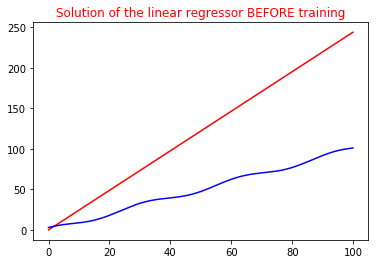

In [8]:
with tf.Session(graph=linear_regression_graph) as sess:
    sess.run(init)
    print("\nParameters before learning")
    print("weights before training: ",sess.run([W]))
    print("bias before training: ",sess.run([b]))
    y_hat = sess.run(y_pred, feed_dict={pl_x:x})
    
plt.title("Solution of the linear regressor BEFORE training", color="red")
plt.plot(x, y_hat, color="red")
plt.plot(x, y,"blue")

In [17]:
n_epochs = 80
batch_size = 50
indices_batches = [ x for x in range(0, len(x) + 1, batch_size) ]
print_every_k = 10

with tf.Session(graph=linear_regression_graph) as sess:
    sess.run(init)
    print("\nParameters before learning")
    print("weights before trainin: ",sess.run([W]))
    print("bias before trainin: ",sess.run([b]))
    print("")
    for epoch in range(n_epochs):
        mean_loss = []
            
        for b_beg, b_end in zip(indices_batches[0:-1], indices_batches[1:]):
            _, l = sess.run([optimizer, loss], feed_dict={pl_x: x[b_beg:b_end], 
                                                          pl_y: y[b_beg:b_end]})
            mean_loss.append(l)
        if epoch % print_every_k+1 ==1:
            print("epoch: ", epoch, " loss: ", np.mean(mean_loss))
        #writer = tf.summary.FileWriter('./my_graph/linear_reg', sess.graph)
    #saver.save(sess, "./saved_tests/linear_regression.cpkt")
    
    #saver.export_meta_graph("./saved_tests/linear_regression_saver.meta")
    print("\nParameters after learning")
    print("weights after training: ",sess.run([W]))
    print("bias after training: ",sess.run([b]))

    ### This saves the graph in a file so we can load it later on
    #saver.save(sess, "./saved_tests/linear_regression.cpkt")
    saver.save(sess, "./saved_tests/linear_regression_saver2.ckpt")
    
    tf.train.export_meta_graph("./saved_tests/linear_regression.cpkt")
    #tf.train.export_meta_graph("./saved_tests/linear_regression.cpkt")


Parameters before learning
weights before trainin:  [array([[ 2.44353771]], dtype=float32)]
bias before trainin:  [array([ 0.], dtype=float32)]

epoch:  0  loss:  29.4748
epoch:  10  loss:  0.451189
epoch:  20  loss:  0.451187
epoch:  30  loss:  0.451184
epoch:  40  loss:  0.451182
epoch:  50  loss:  0.451179
epoch:  60  loss:  0.451177
epoch:  70  loss:  0.451175

Parameters after learning
weights after training:  [array([[ 1.01382041]], dtype=float32)]
bias after training:  [array([-0.05821415], dtype=float32)]


INFO:tensorflow:Restoring parameters from ./saved_tests/linear_regression_saver2.ckpt

Parameters after learning
weights before training:  [array([[ 1.01382041]], dtype=float32)]
bias before training:  [array([-0.05821415], dtype=float32)]


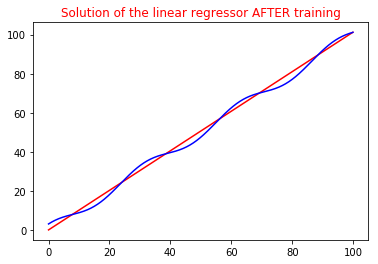

In [18]:

with tf.Session(graph=linear_regression_graph) as sess:
    saver.restore(sess,"./saved_tests/linear_regression_saver2.ckpt") 
    print("\nParameters after learning")
    print("weights before training: ",sess.run([W]))
    print("bias before training: ",sess.run([b]))
    y_hat = sess.run(y_pred, feed_dict={pl_x:x})

plt.title("Solution of the linear regressor AFTER training", color="red")
plt.plot(x, y_hat, color="red")
plt.plot(x, y,"blue")


### Retraining in a new session using a past saved session

In [19]:
tf.reset_default_graph()
batch_size_ = 10
n_features_ = 1
linear_regression_graph = tf.Graph()
seed_val = 123

with linear_regression_graph.as_default():
    batch_size = batch_size_
    n_features = n_features_

    pl_x = tf.placeholder(name="pl_x", dtype=tf.float32, shape=(None, 1))
    pl_y = tf.placeholder(name="pl_y", dtype=tf.float32, shape=(None, 1))
    W = tf.get_variable("weights", (1,1), initializer=tf.random_normal_initializer(seed=seed_val))
    b = tf.get_variable("bias", (1,), initializer=tf.constant_initializer(0.))
    y_pred = tf.matmul(pl_x, W) + b    
    loss = tf.reduce_mean((pl_y - y_pred)**2/batch_size)
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(loss)
    
    # Add allways the  tf.global_variables_initializer() and tf.Saver() in the graph
    init = tf.global_variables_initializer()   
    saver = tf.train.Saver()
    #saver.save(as_default, "./saved_tests/linear_regression_saver.ckpt")
    pprint.pprint(tf.global_variables())


[<tf.Variable 'weights:0' shape=(1, 1) dtype=float32_ref>,
 <tf.Variable 'bias:0' shape=(1,) dtype=float32_ref>]


In [20]:
tf.reset_default_graph()
batch_size = 80
n_epochs = 50
indices_batches = [ x for x in range(0, len(x) + 1, batch_size) ]

with tf.Session(graph=linear_regression_graph) as sess:
    saver.restore(sess,"./saved_tests/linear_regression_saver2.ckpt") 
    #saver.import_meta_graph("./saved_tests/linear_regression_saver.meta")
    print("\n\nShow me W and b")
    print("weights after training: ",sess.run([W]))
    print("bias after training: ",sess.run([b]), "\n")
    
    for epoch in range(n_epochs):
        mean_loss = []
        for b_beg, b_end in zip(indices_batches[0:-1], indices_batches[1:]):
            _, l = sess.run([optimizer, loss], feed_dict={pl_x: x[b_beg:b_end], 
                                                          pl_y: y[b_beg:b_end]})
            mean_loss.append(l)
        print("epoch: ", epoch, " loss: ", np.mean(mean_loss))


INFO:tensorflow:Restoring parameters from ./saved_tests/linear_regression_saver2.ckpt


Show me W and b
weights after training:  [array([[ 1.01382041]], dtype=float32)]
bias after training:  [array([-0.05821415], dtype=float32)] 

epoch:  0  loss:  0.647058
epoch:  1  loss:  0.698808
epoch:  2  loss:  0.69877
epoch:  3  loss:  0.698744
epoch:  4  loss:  0.698719
epoch:  5  loss:  0.698692
epoch:  6  loss:  0.698667
epoch:  7  loss:  0.698641
epoch:  8  loss:  0.698616
epoch:  9  loss:  0.69859
epoch:  10  loss:  0.698565
epoch:  11  loss:  0.698539
epoch:  12  loss:  0.698513
epoch:  13  loss:  0.698487
epoch:  14  loss:  0.698462
epoch:  15  loss:  0.698437
epoch:  16  loss:  0.698411
epoch:  17  loss:  0.698386
epoch:  18  loss:  0.69836
epoch:  19  loss:  0.698335
epoch:  20  loss:  0.698311
epoch:  21  loss:  0.698284
epoch:  22  loss:  0.698259
epoch:  23  loss:  0.698234
epoch:  24  loss:  0.69821
epoch:  25  loss:  0.698184
epoch:  26  loss:  0.698159
epoch:  27  loss:  0.698134

In [21]:
#with tf.gfile.FastGFile("./saved_tests/linear_regression.cpkt") as f:
#    graph_def = tf.GraphDef()
#    graph_def.ParseFromString(f.read())
#    _ = tf.import_graph_def(graph_def, name="")

### Export a MetaGraph

A MetaGraph contains both a TensorFlow GraphDef as well as associated metadata necessary for running computation in a graph when crossing a process boundary. It can also be used for long term storage of graphs.

The MetaGraph contains the information required to continue training, perform evaluation, or run inference on a previously trained graph.

The APIs for exporting and importing the complete model are in the ``tf.train.Saver`` class: ``tf.train.export_meta_graph`` and ``tf.train.import_meta_graph``.

#### Inside a metagraph

The information contained in a MetaGraph is expressed as a MetaGraphDef protocol buffer. It contains the following fields:

- **MetaInfoDef** for meta information, such as version and other user information.

- **GraphDef** for describing the graph.

- **SaverDef** for the saver.

- **CollectionDef** map that further describes additional components of the model, such as ``Variables``, ``tf.train.QueueRunner``, etc. In order for a Python object to be serialized to and from MetaGraphDef, the Python class must implement ``to_proto()`` and ``from_proto()`` methods, and register them with the system using register_proto_function.
